# Particle Marginal Metropolis Hastings Test

In [1918]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Bootstrap Particle Filter Implementation

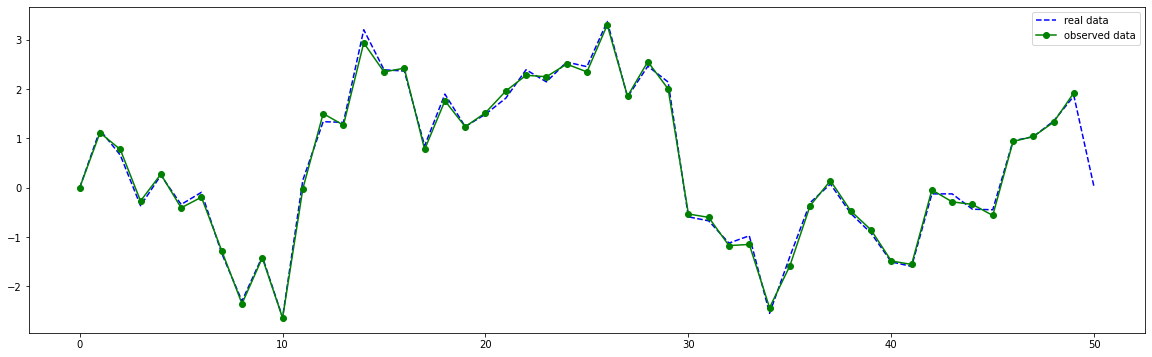

In [1987]:
# Initialize values
def generateData(theta, noObservations, initialState):
    phi = theta[0]
    sigmav = theta[1]
    sigmae = theta[2]

    state = np.zeros(noObservations + 1)
    observation = np.zeros(noObservations)
    state[0] = initialState

    for t in range(1, noObservations):
        state[t] = phi * state[t - 1] + sigmav * stats.norm(0,1).rvs()
        observation[t] = state[t] + sigmae * stats.norm(0,1).rvs()

    return(state, observation)

phi = 0.75
sigma_v = 1
sigma_w = 0.1

theta = (phi, sigma_v, sigma_w)
T = 50
initialState = 0

states, observations = generateData(theta,T,initialState)

plt.figure(figsize=(20,6))
plt.plot(range(T+1), states, color='blue', linestyle = '--',label='real data')
plt.plot(range(T), observations, color='green', marker='o', linestyle='-',label='observed data')

plt.legend()
plt.show()

In [1996]:
def bootstrap_filter(y, theta, num_particles, init_states):
    phi, sigmav, sigmae =  theta
    T = len(y)
    
    #Initialization
    weights = np.full((num_particles, T), np.nan)
    norm_weights = np.full((num_particles, T), np.nan) 
    particles = np.full((num_particles,T), np.nan)
    ancestor_indices = np.full((num_particles, T), np.nan)
    ESS = np.full(T, np.nan)

    estimated_states = np.full(T, np.nan)
    
    #Set the initial states and weights
    ancestor_indices[:,0] = np.arange(num_particles)
    particles[:,0] = init_states
    weights[:,0] = 1 / num_particles 
    norm_weights[:,0] = weights[:,0] 

    estimated_states[0] = np.sum(norm_weights[:,0]*particles[:,0])
    marginal_loglikelihood = 0
    ESS[0] = 1/(norm_weights[:,0]**2).sum()
      
    for t in range(1,T):
        #Multinomial resampling
        new_ancestors = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:,t-1], replace=True) #resample particles
        ancestor_indices[:,1:t-1] = ancestor_indices[new_ancestors,1:t-1] #resample particle lineage
        ancestor_indices[:,t] = new_ancestors
        
        #Transition Step Article
     
        part1 = (sigmav**(-2) + sigmae**(-2))**(-1)
        part2 = sigmae**(-2) * y[t]
        part2 = part2 + sigmav**(-2) * phi * particles[new_ancestors, t - 1]
        particles[:, t] = part1 * part2 + np.sqrt(part1) * stats.norm(0,1).rvs(num_particles)
        
        # Compute weights
        yhatMean = phi * particles[:, t]
        yhatVariance = np.sqrt(sigmav**2 + sigmae**2)
        weights[:, t] = stats.norm(yhatMean, yhatVariance).logpdf(observations[t])

        max_weights = np.max(weights[:, t])
        weights[:, t] = np.exp(weights[:, t] - max_weights)
        sum_weights = np.sum(weights[:, t])
        norm_weights[:, t] = weights[:, t] / sum_weights

        #Transition Step Bootstrap
        #particles[:,t] = phi*particles[new_ancestors,t-1] + stats.norm(0,sigmav).rvs(num_particles)
        #Update Step
        #incremental_weight = stats.norm(particles[:,t], sigmae).logpdf(y[t])
        #max_weights = np.max(incremental_weight)
        #weights[:, t] = weights[:,t-1]*np.exp(incremental_weight-max_weights)
        #sum_weights = weights[:,t].sum() 
        #norm_weights[:, t] = weights[:,t] / sum_weights
        
        estimated_states[t] = np.sum(norm_weights[:,t]*particles[:,t])
        marginal_loglikelihood += max_weights + np.log(sum_weights) - np.log(num_particles)
        ESS[t] = 1/(norm_weights[:,t]**2).sum()
    
    return particles, ancestor_indices, marginal_loglikelihood, ESS
    

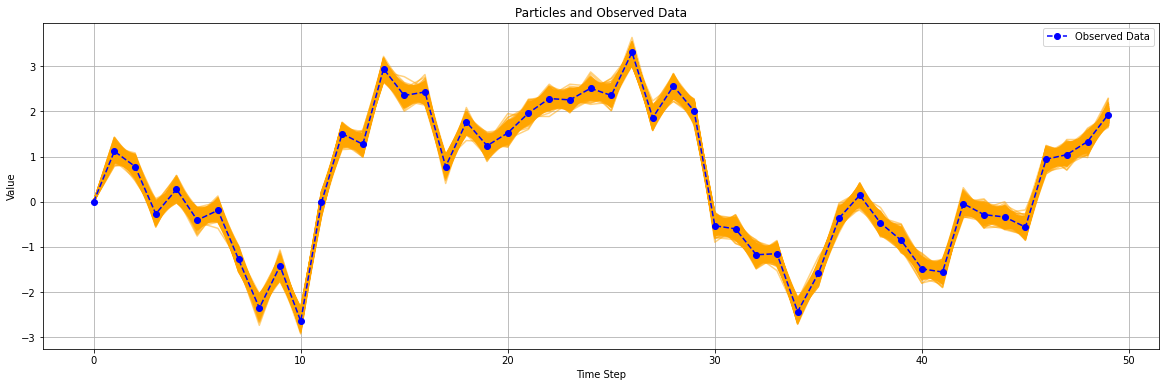

In [1997]:
num_particles = 1000
init_states = 0
phi = 0.75
sigma_v = 1
sigma_w = 0.1
params = (phi, sigma_v, sigma_w)

particles, ancestor_indices, marginal_loglikelihood, ESS = bootstrap_filter(observations, params, num_particles, init_states)

plt.figure(figsize=(20, 6))

# Plot particles using a line plot
for particle in range(num_particles):
    plt.plot(np.arange(T), particles[particle, :], color='orange', alpha=0.5)

# Plot observed data
plt.plot(np.arange(T), observations, color='blue', marker='o', linestyle='--', label='Observed Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Particles and Observed Data')
plt.legend()
plt.grid(True)
plt.show()

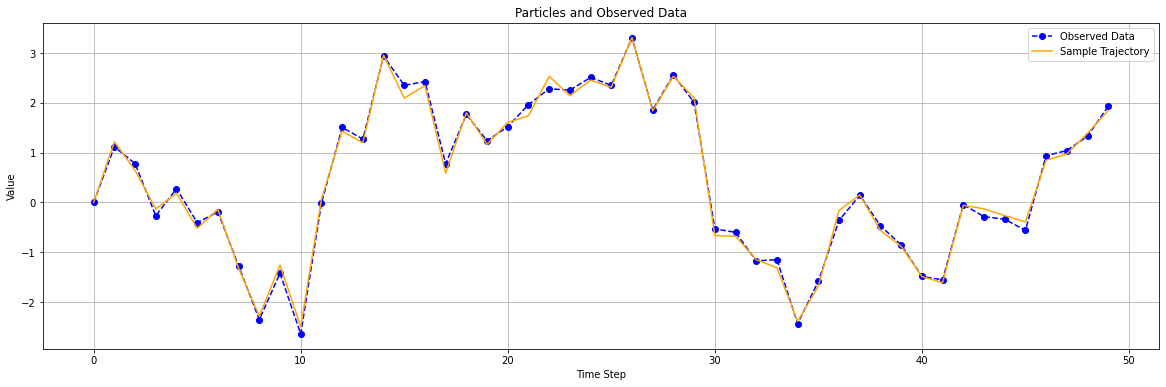

In [1998]:
def sample_trajectory(ancestry_matrix, particles_matrix):
    num_time_steps = ancestry_matrix.shape[1]
    num_particles = ancestry_matrix.shape[0]
    trajectory = np.zeros(num_time_steps)  # Initialize the trajectory array
    
    # Sample the particle index from the last time step
    sampled_index = np.random.choice(np.arange(num_particles)).astype(int)
    trajectory[-1] = particles_matrix[sampled_index, -1]
    
    # Recursively sample particles from previous time steps
    for t in range(num_time_steps - 2, -1, -1):  # Iterate backward in time
        # Get the ancestor index at the previous time step
        sampled_index = ancestry_matrix[sampled_index, t].astype(int)
        # Update the trajectory array with the state from the particles matrix
        trajectory[t] = particles_matrix[sampled_index, t]
    
    return trajectory

plt.figure(figsize=(20, 6))

# Plot observed data
plt.plot(np.arange(T), observations, color='blue', marker='o', linestyle='--', label='Observed Data')

# Plot sampled trajectory  
plt.plot(np.arange(T), sample_trajectory(ancestor_indices, particles), color='orange', label='Sample Trajectory')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Particles and Observed Data')
plt.legend()
plt.grid(True)
plt.show()

## Particle Marginal MH Implementation

In [1991]:
T = observations.shape[0]
n_mh = 5000
num_particles = 1000
step_size = 0.10

phi = np.full(n_mh, np.nan)
phi_proposed = np.full(n_mh, np.nan)

log_likelihood = np.full(n_mh, np.nan)
log_likelihood_proposed = np.full(n_mh, np.nan)
proposed_phi_accepted = np.full(n_mh, 0)

sample_trajectories = np.full((n_mh,T),np.nan)

phi[0] = 0.5
init_states = 0
params = (phi[0], 1, 0.1)
particles, ancestor_indices, marginal_loglikelihood, ESS = bootstrap_filter(observations, params, num_particles, init_states)
sample_trajectories[0,:] = sample_trajectory(ancestor_indices, particles)
log_likelihood[0] = marginal_loglikelihood

for k in range(1,n_mh):
    #Propose new parameter
    phi_proposed[k] = phi[k-1] + step_size*stats.norm(0,1).rvs()
    
    #Compute marginal log-likelihood for proposed parameter value
    if (0 < phi_proposed[k] <1):
        params = (phi_proposed[k], sigma_v, sigma_w)
        particles, ancestor_indices, marginal_loglikelihood, ESS = bootstrap_filter(observations, params, num_particles, init_states)
        log_likelihood_proposed[k] = marginal_loglikelihood

    #Calculate accept reject probability
    #prior_part = stats.norm(0,0.5).logpdf(phi_proposed[k]) - stats.norm(0,0.5).logpdf(phi[k-1])
    likelihood_part = log_likelihood_proposed[k] - log_likelihood[k-1]
    accept_probability = np.minimum(1.0 ,np.exp(likelihood_part))
    accept_probability *= (0 < phi_proposed[k] <1)
    
    #Accept/Reject step
    u = stats.uniform(0,1).rvs()
    if u < accept_probability:
        phi[k] = phi_proposed[k]
        log_likelihood[k] = log_likelihood_proposed[k]
        proposed_phi_accepted[k]=1
        sample_trajectories[k,:] = sample_trajectory(ancestor_indices, particles)
    else:
        phi[k] = phi[k-1]
        log_likelihood[k] = log_likelihood[k-1]
        proposed_phi_accepted[k]=0
        sample_trajectories[k,:] = sample_trajectories[k-1,:]
        
    # Write out progress
    if np.remainder(k, 100) == 0:
        print("#####################################################################")
        print(" Iteration: " + str(k) + " of : " + str(n_mh) + " completed.")
        print("")
        print(" Current state of the Markov chain:       " + "%.4f" % phi[k] + ".")
        print(" Proposed next state of the Markov chain: " + "%.4f" % phi_proposed[k] + ".")
        print(" Current posterior mean:                  " + "%.4f" % np.mean(phi[0:k]) + ".")
        print(" Current acceptance rate:                 " + "%.4f" % np.mean(proposed_phi_accepted[0:k]) + ".")
        print("#####################################################################")

#####################################################################
 Iteration: 100 of : 5000 completed.

 Current state of the Markov chain:       0.9024.
 Proposed next state of the Markov chain: 0.8528.
 Current posterior mean:                  0.9103.
 Current acceptance rate:                 0.5300.
#####################################################################
#####################################################################
 Iteration: 200 of : 5000 completed.

 Current state of the Markov chain:       0.9669.
 Proposed next state of the Markov chain: 0.8917.
 Current posterior mean:                  0.9162.
 Current acceptance rate:                 0.5200.
#####################################################################
#####################################################################
 Iteration: 300 of : 5000 completed.

 Current state of the Markov chain:       0.9275.
 Proposed next state of the Markov chain: 0.9275.
 Current posterior mean:            

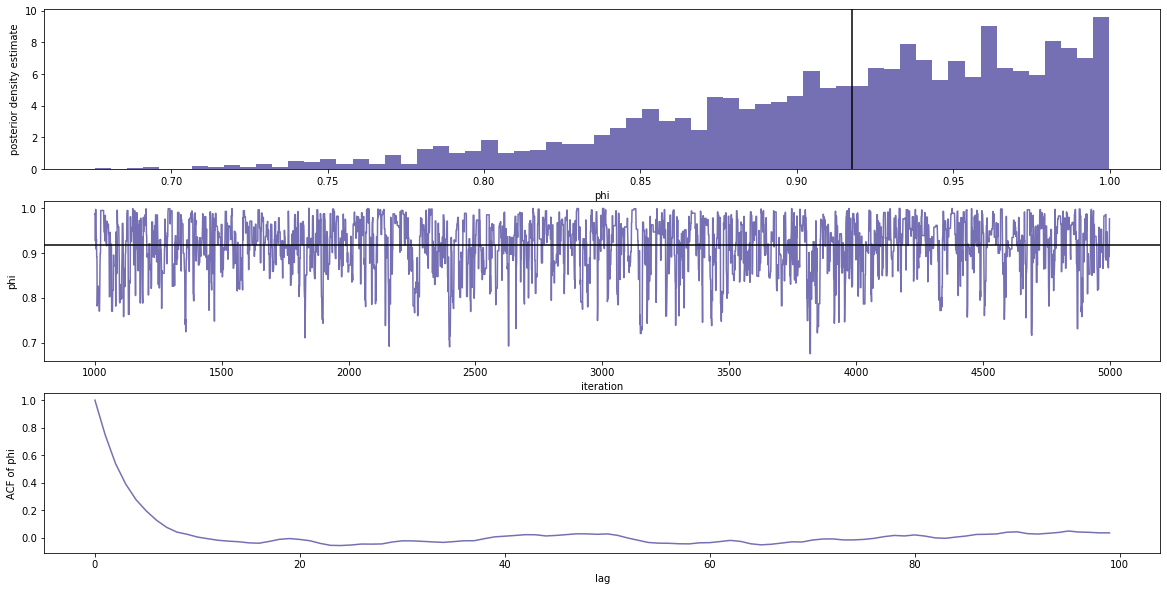

In [1986]:
burnin = 1000
noBins = int(np.floor(np.sqrt(n_mh - burnin)))
grid = np.arange(burnin, n_mh, 1)
phi_plot = phi[burnin:n_mh]

# Plot the parameter posterior estimate (solid black line = posterior mean)
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.hist(phi_plot, noBins, density=True, facecolor='#7570B3')
plt.xlabel("phi")
plt.ylabel("posterior density estimate")
plt.axvline(np.mean(phi_plot), color='k')

# Plot the trace of the Markov chain after burn-in (solid black line = posterior mean)
plt.subplot(3, 1, 2)
plt.plot(grid, phi_plot, color='#7570B3')
plt.xlabel("iteration")
plt.ylabel("phi")
plt.axhline(np.mean(phi_plot), color='k')

# Plot the autocorrelation function
plt.subplot(3, 1, 3)
macf = np.correlate(phi_plot - np.mean(phi_plot), phi_plot - np.mean(phi_plot), mode='full')
idx = int(macf.size/2)
macf = macf[idx:]
macf = macf[0:100]
macf /= macf[0]
grid = range(len(macf))
plt.plot(grid, macf, color='#7570B3')
plt.xlabel("lag")
plt.ylabel("ACF of phi")

plt.show()

In [1976]:
def particleFilter(observations, parameters, noParticles, initialState):
        
    noObservations = len(observations) - 1
    phi = parameters[0]
    sigmav = parameters[1]
    sigmae = parameters[2]

    particles = np.zeros((noParticles, noObservations))
    ancestorIndices = np.zeros((noParticles, noObservations))
    weights = np.zeros((noParticles, noObservations))
    normalisedWeights = np.zeros((noParticles, noObservations))
    xHatFiltered = np.zeros((noObservations, 1))

    # Set the initial state and weights
    ancestorIndices[: , 0] = range(noParticles)
    particles[:, 0] = initialState
    xHatFiltered[0] = initialState
    normalisedWeights[:, 0] = 1.0 / noParticles
    logLikelihood = 0

    for t in range(1, noObservations):
        # Resample (multinomial)
        newAncestors = np.random.choice(noParticles, noParticles, p=normalisedWeights[:, t - 1], replace=True)
        ancestorIndices[:, 1:t - 1] = ancestorIndices[newAncestors, 1:t - 1]
        ancestorIndices[:, t] = newAncestors

        # Propagate
        part1 = (sigmav**(-2) + sigmae**(-2))**(-1)
        part2 = sigmae**(-2) * observations[t]
        part2 = part2 + sigmav**(-2) * phi * particles[newAncestors, t - 1]
        particles[:, t] = part1 * part2 + np.sqrt(part1) * stats.norm(0,1).rvs(noParticles)

        # Compute weights
        yhatMean = phi * particles[:, t]
        yhatVariance = np.sqrt(sigmav**2 + sigmae**2)
        weights[:, t] = stats.norm(yhatMean, yhatVariance).logpdf(observations[t + 1])

        maxWeight = np.max(weights[:, t])
        weights[:, t] = np.exp(weights[:, t] - maxWeight)
        sumWeights = np.sum(weights[:, t])
        normalisedWeights[:, t] = weights[:, t] / sumWeights

        # Estimate the state
        xHatFiltered[t] = np.sum(normalisedWeights[:, t] * particles[:, t])

        # Estimate log-likelihood
        predictiveLikelihood = maxWeight + np.log(sumWeights) - np.log(noParticles)
        logLikelihood += predictiveLikelihood

    return xHatFiltered, logLikelihood

def particleMetropolisHastings(observations, initialPhi, parameters, noParticles, 
        initialState, particleFilter, noIterations, stepSize):

    phi = np.zeros(noIterations)
    phiProposed = np.zeros(noIterations)
    logLikelihood = np.zeros(noIterations)
    logLikelihoodProposed = np.zeros(noIterations)
    proposedPhiAccepted = np.zeros(noIterations)

    # Set the initial parameter and estimate the initial log-likelihood
    phi[0] = initialPhi
    _, logLikelihood[0] = particleFilter(observations, (phi[0], parameters[1], parameters[2]), noParticles, initialState)

    for k in range(1, noIterations):
        # Propose a new parameter
        phiProposed[k] = phi[k - 1] + stepSize * stats.norm(0,1).rvs()

        # Estimate the log-likelihood if the proposed phi results in a stable model
        if (np.abs(phiProposed[k]) < 1.0):
            _, logLikelihoodProposed[k] = particleFilter(observations, (phiProposed[k], parameters[1], parameters[2]), noParticles, initialState)

        # Compute the acceptance probability
        acceptProbability = np.min((1.0, np.exp(logLikelihoodProposed[k] - logLikelihood[k - 1])))
        acceptProbability *= np.abs(phiProposed[k]) < 1.0
        
        # Accept / reject step
        uniformRandomVariable = stats.uniform(0,1).rvs()
        if uniformRandomVariable < acceptProbability:
            # Accept the parameter
            phi[k] = phiProposed[k]
            logLikelihood[k] = logLikelihoodProposed[k]
            proposedPhiAccepted[k] = 1.0
        else:
            # Reject the parameter
            phi[k] = phi[k - 1]
            logLikelihood[k] = logLikelihood[k - 1]
            proposedPhiAccepted[k] = 0.0

        # Write out progress
        if np.remainder(k, 100) == 0:
            print("#####################################################################")
            print(" Iteration: " + str(k) + " of : " + str(noIterations) + " completed.")
            print("")
            print(" Current state of the Markov chain:       " + "%.4f" % phi[k] + ".")
            print(" Proposed next state of the Markov chain: " + "%.4f" % phiProposed[k] + ".")
            print(" Current posterior mean:                  " + "%.4f" % np.mean(phi[0:k]) + ".")
            print(" Current acceptance rate:                 " + "%.4f" % np.mean(proposedPhiAccepted[0:k]) + ".")
            print("#####################################################################")
    
    return phi

initialPhi = 0.50
noParticles = 500           # Use noParticles ~ noObservations
noBurnInIterations = 1000
noIterations = 5000
stepSize = 0.10

parameters = (initialPhi, 10, 10)

phiTrace = particleMetropolisHastings(observations, initialPhi, parameters, noParticles, initialState, particleFilter, noIterations, stepSize)

#####################################################################
 Iteration: 100 of : 5000 completed.

 Current state of the Markov chain:       0.7627.
 Proposed next state of the Markov chain: 0.7646.
 Current posterior mean:                  0.8338.
 Current acceptance rate:                 0.7000.
#####################################################################
#####################################################################
 Iteration: 200 of : 5000 completed.

 Current state of the Markov chain:       0.8371.
 Proposed next state of the Markov chain: 0.8371.
 Current posterior mean:                  0.8333.
 Current acceptance rate:                 0.6750.
#####################################################################
#####################################################################
 Iteration: 300 of : 5000 completed.

 Current state of the Markov chain:       0.8223.
 Proposed next state of the Markov chain: 0.7973.
 Current posterior mean:            

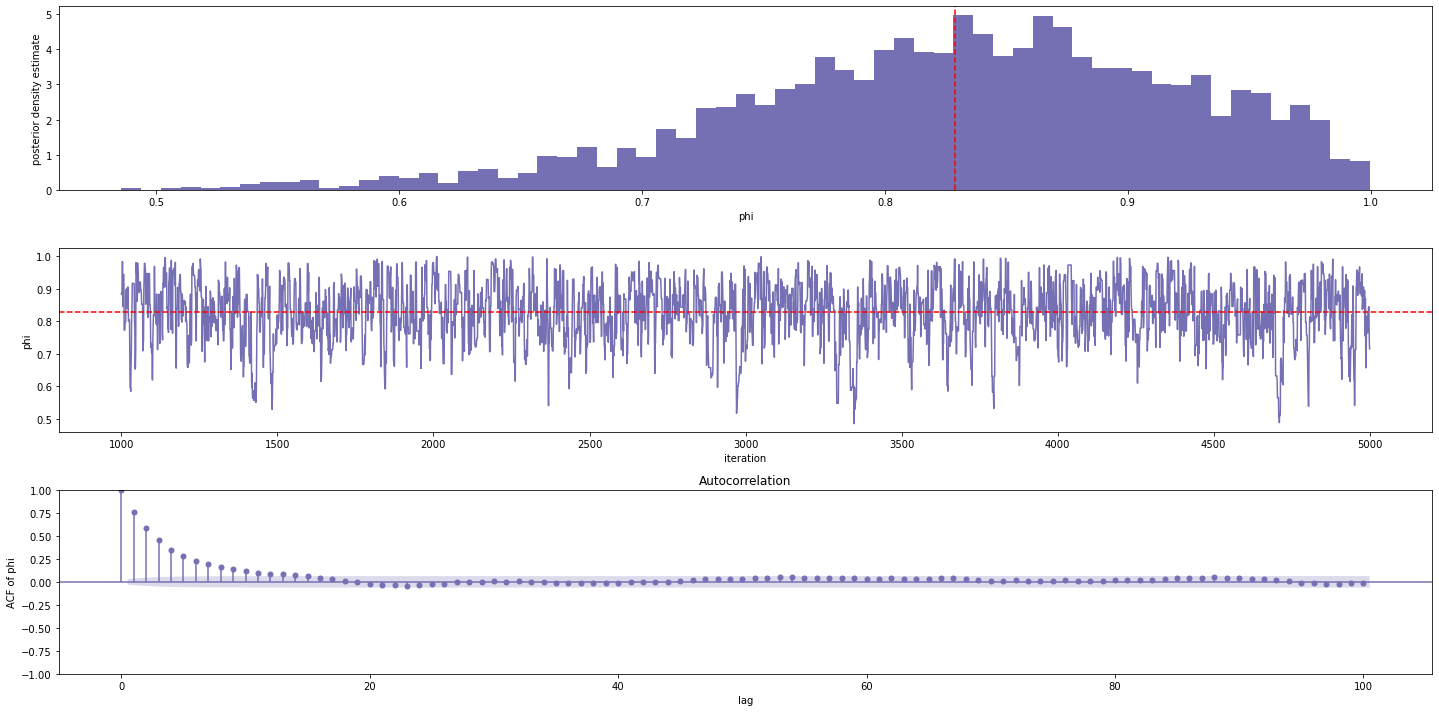

In [1977]:
burnin = 1000
noBins = int(np.floor(np.sqrt(n_mh - burnin)))
grid = np.arange(burnin, 5000, 1)
phi_plot_2 = phiTrace[burnin:n_mh]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# Plot the parameter posterior estimate (solid black line = posterior mean)
axs[0].hist(phi_plot_2, noBins, density=True, facecolor='#7570B3')
axs[0].set_xlabel("phi")
axs[0].set_ylabel("posterior density estimate")
axs[0].axvline(np.mean(phi_plot_2), color='red', linestyle='--')

# Plot the trace of the Markov chain after burn-in (solid black line = posterior mean)
axs[1].plot(grid, phi_plot_2, color='#7570B3')
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("phi")
axs[1].axhline(np.mean(phi_plot_2), color='r', linestyle='--')

# Plot the autocorrelation function
sm.graphics.tsa.plot_acf(phi_plot_2, lags=100, ax=axs[2], color='#7570B3', vlines_kwargs={"colors": '#7570B3'})
for item in axs[2].collections:
    item.set_facecolor('#7570B3')
        
axs[2].set_xlabel("lag")
axs[2].set_ylabel("ACF of phi")

plt.tight_layout()
plt.show()